In [76]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
df = pd.read_csv('titanic.csv')

In [24]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
# Basic overview
df.info()
df.describe(include="all")

# Missing values summary
df.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [104]:
features = ["Pclass", "Sex", "Embarked", "SibSp", "Parch"]

for col in features:
    display(df.groupby(col)["Survived"].mean().to_frame("Survival Rate"))

,Survival Rate
Pclass,
1,0.629630
2,0.472826
3,0.242363


,Survival Rate
Sex,
female,0.742038
male,0.188908


,Survival Rate
Embarked,
C,0.553571
Q,0.389610
S,0.339009


,Survival Rate
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


,Survival Rate
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


### Survival Rate Analysis

To understand which features were associated with higher or lower survival probability, 
we computed survival rates across key categorical and discrete variables:

**Pclass:** Survival rate increases strongly with class — passengers of 1st class survived much more often than 2nd or 3rd class, reflecting better physical access to lifeboats.

**Sex:** Females survived at a dramatically higher rate than males, consistent with the “women and children first” evacuation policy.

**Embarked:** Port of embarkation shows weaker effects, but passengers from port C tend to have slightly higher survival rates.

**SibSp and Parch:** Passengers traveling completely alone or in very large families had lower chances of survival, while small families (1–2 relatives) survived more often.

These patterns help us understand the structure behind the model’s future feature importances
and validate that the dataset follows historically expected behaviors.


In [40]:
cols_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
df = df.drop(columns=cols_to_drop)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [46]:
# Features with missing values: Age, Embarked

# Age: fill with median
df["Age"] = df["Age"].fillna(df["Age"].median())

# Embarked: fill with mode
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Double-check
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [48]:
categorical_cols = ["Sex", "Embarked", "Pclass"]
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df_encoded.head()

,Survived,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,True,False,True,False,True
1,1,38.0,1,0,71.2833,False,False,False,False,False
2,1,26.0,0,0,7.9250,False,False,True,False,True
3,1,35.0,1,0,53.1000,False,False,True,False,False
4,0,35.0,0,0,8.0500,True,False,True,False,True


In [54]:
# split train and test datasets for dependent variable 'Survived'
X = df_encoded.drop(columns=["Survived"])
y = df_encoded["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((712, 9), (179, 9))

In [64]:
# Train Decision Tree baseline
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8156424581005587

Confusion matrix:
 [[94 16]
 [17 52]]

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.76      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



In [109]:
print("Tree depth:", clf.get_depth())
print("Number of leaves:", clf.get_n_leaves())

Tree depth: 20
Number of leaves: 156


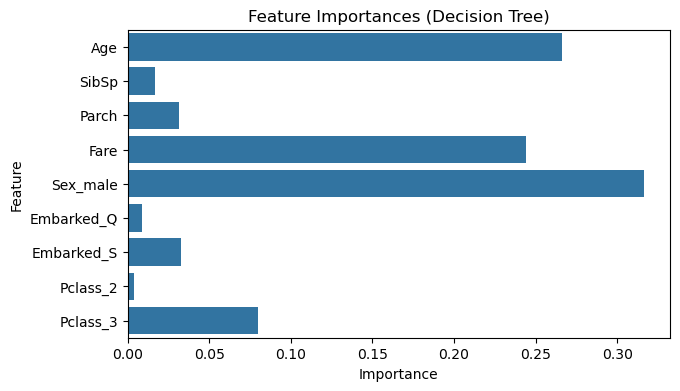

Sex_male      0.316638
Age           0.266301
Fare          0.243906
Pclass_3      0.080186
Embarked_S    0.032543
Parch         0.031285
SibSp         0.016714
Embarked_Q    0.008729
Pclass_2      0.003698
dtype: float64

In [81]:
# Feature Importance

feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)

plt.figure(figsize=(7,4))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig("feature_importances.png", dpi=300, bbox_inches='tight')
plt.show()

feature_importances.sort_values(ascending=False)

### Interpretation of Feature Importances

The decision tree identifies **Sex (male/female)** as the most influential predictor of survival — reflecting the historical “women and children first” evacuation rule.  
**Age** also plays a strong role: younger passengers had a higher chance of survival.  
The tree assigns high importance to the indicator for 3rd class (**Pclass_3**), meaning that being in 3rd class provides strong information for distinguishing survivors from non-survivors.  
This does not mean that 3rd class increases surval — rather the opposite: 3rd-class passengers historically had much lower survival rates, and the model uses this strong negative signal for splitting.  
Consequently, **Fare** and **Pclass** capture socio-economic status, where higher-class passengers had better access to lifeboats.  
Family-related features (**SibSp**, **Parch**) contribute less but still provide useful information about group survival patterns.  
**Embarked** also shows minimal importance.


In [107]:
# Experimental evaluation of the model performance for different tree depths
# to detect underfitting (too shallow) vs overfitting (too deep)
# Depth values tested: 2, 4, 6, and None (unrestricted depth)

depths = [2, 4, 6, None]
results = {}

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    
    results[d] = acc
    print(f"Depth={d}: accuracy = {acc:.4f}")


Depth=2: accuracy = 0.7598
Depth=4: accuracy = 0.7989
Depth=6: accuracy = 0.8045
Depth=None: accuracy = 0.8156


## Interpretation of Depth Experiment Results

Testing different values of `max_depth` shows a clear pattern in model behavior:

- **Depth = 2** yields the lowest accuracy (0.7598), indicating **underfitting** — the model is too simple and cannot capture the structure of the data.
- **Depth = 4** improves accuracy (0.7989), but the decision boundary remains not expressive enough.
- **Depth = 6** performs better (0.8045), suggesting a more optimal balance between complexity and generalization.
- **Depth = None** (unrestricted depth) provides the highest accuracy (0.8156).  
  This means that, for the Titanic dataset, deeper trees still capture meaningful interactions between features without strong overfitting on the test set.

Overall, increasing tree depth reduces underfitting. In this experiment, the **unrestricted-depth tree performed best**, indicating that the model benefits from additional depth on this dataset.
